# importing required modules and libraries

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers


In [17]:
data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/peeper',
                                                           shuffle = True,
                                                           batch_size = 16,
                                                           image_size = (256, 256),)

Found 2475 files belonging to 2 classes.


In [18]:
classes = data.class_names
classes

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

(-0.5, 255.5, 255.5, -0.5)

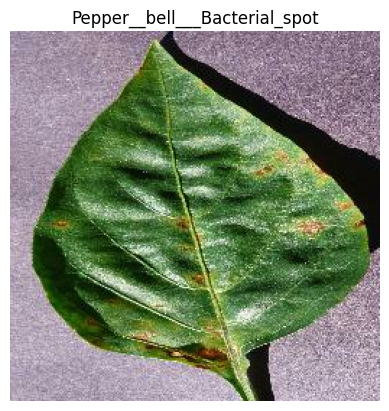

In [19]:
for img_batch, label_batch in data.take(1):
  image = img_batch[0].numpy().astype('uint8')
  label = label_batch[0].numpy()

plt.title(classes[label])
plt.imshow(image)
plt.axis('off')

In [20]:
len(data)

155

In [21]:
def get_data_partition(ds, train = 0.8, test = 0.1, val = 0.1, shuffle =True, shuffle_size = 10000 ):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 10)

  data_size = len(data)

  train_size = int(train * data_size)
  val_size = int(val * data_size)

  train_ds = data.take(train_size)
  val_ds = data.skip(train_size).take(val_size)
  test_ds = data.skip(train_size).skip(val_size)

  return train_ds, test_ds, val_ds

In [22]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1.0/255),
])

In [23]:
train, test, val = get_data_partition(data)

train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val =  val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
augm = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2,0.3),
])

In [25]:
train =  train.map(
    lambda x,y : (augm(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [26]:
n_classes = 2
ip_shp = (16, 256, 256, 3)

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=ip_shp),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=ip_shp)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (16, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (16, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (16, 60, 60, 64)         

In [27]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [28]:
history = model.fit(
    train,
    validation_data=val,
    batch_size=16,
    verbose=1,
    epochs=5,
)

Epoch 1/5
124/124 [==============================] - 44s 280ms/step - loss: 0.5023 - accuracy: 0.7475 - val_loss: 0.3180 - val_accuracy: 0.9458
Epoch 2/5
124/124 [==============================] - 30s 240ms/step - loss: 0.3021 - accuracy: 0.9047 - val_loss: 0.1032 - val_accuracy: 0.9500
Epoch 3/5
124/124 [==============================] - 29s 231ms/step - loss: 0.1480 - accuracy: 0.9607 - val_loss: 0.0315 - val_accuracy: 0.9917
Epoch 4/5
124/124 [==============================] - 29s 236ms/step - loss: 0.0738 - accuracy: 0.9814 - val_loss: 0.0229 - val_accuracy: 0.9917
Epoch 5/5
124/124 [==============================] - 29s 230ms/step - loss: 0.0870 - accuracy: 0.9753 - val_loss: 0.1075 - val_accuracy: 0.9375


In [29]:
model.evaluate(test)

16/16 [==============================] - 8s 39ms/step - loss: 0.1792 - accuracy: 0.9004


[0.17919285595417023, 0.9003984332084656]

1/1 [==============================] - 0s 18ms/step


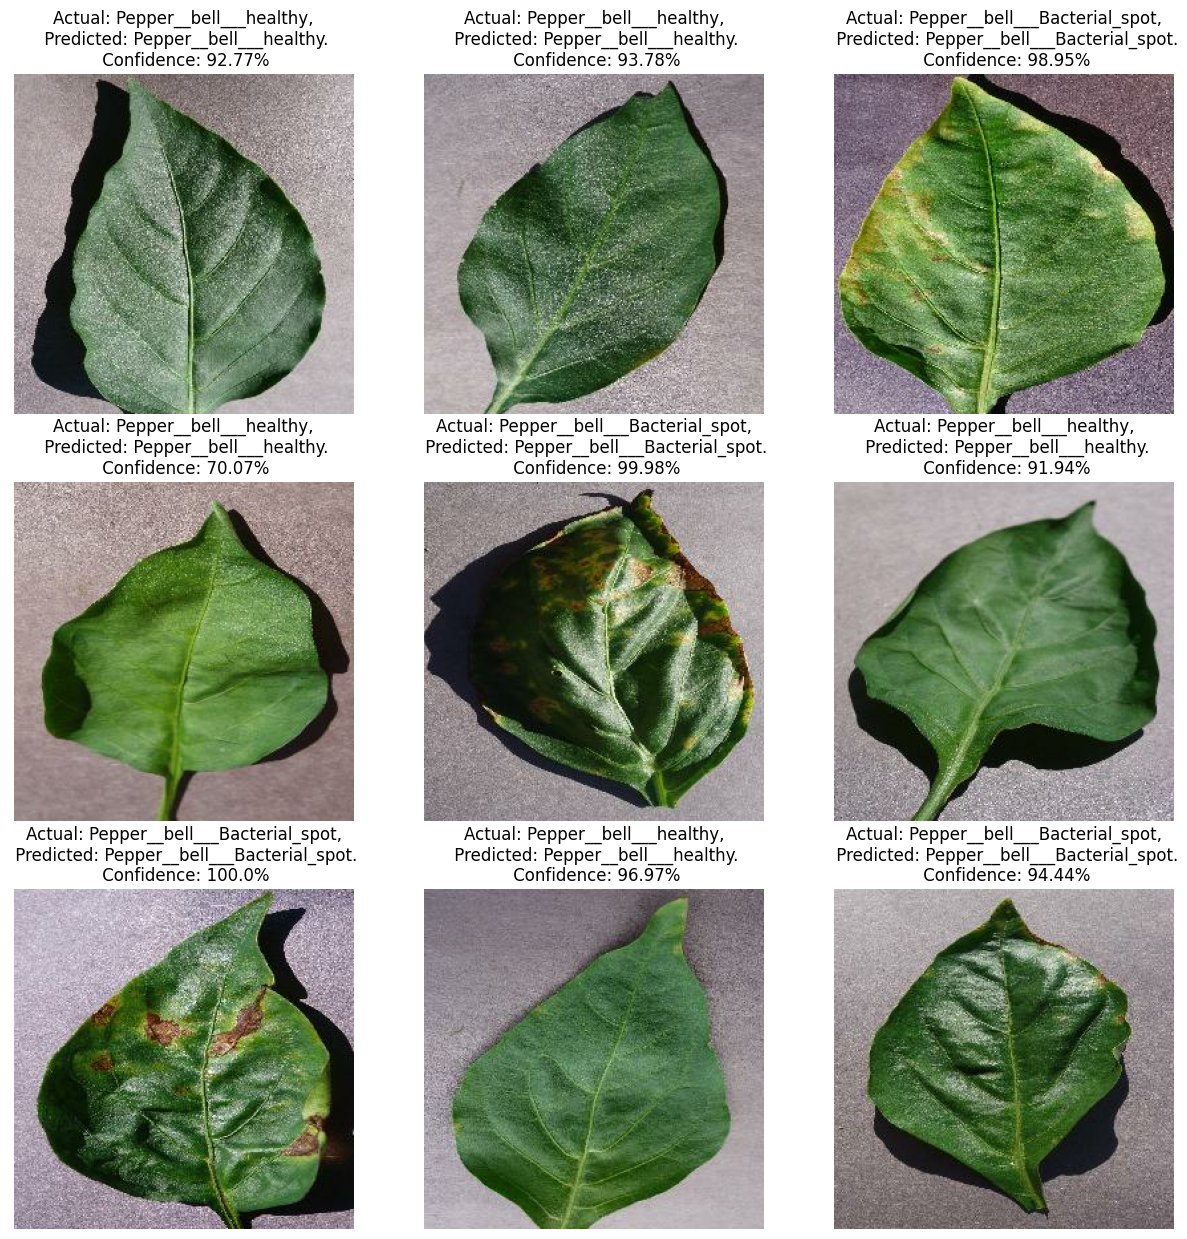

In [39]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions)]
    confidence = round(100 * (np.max(predictions)), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [40]:
model.save("pepper_e5.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
